In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [3]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [5]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [6]:
# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [7]:
import os 
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain_openai import ChatOpenAI
from pydantic import SecretStr

# Model Claude 4.5
# model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# use openrouter for cheap, efficient models
model = ChatOpenAI(
    model="x-ai/grok-4.1-fast", 
    
    # redirect LangChain to OpenRouter
    base_url="https://openrouter.ai/api/v1",

    # pass the OpenRouter key
    api_key=SecretStr(os.environ["OPENROUTER_API_KEY"])
)

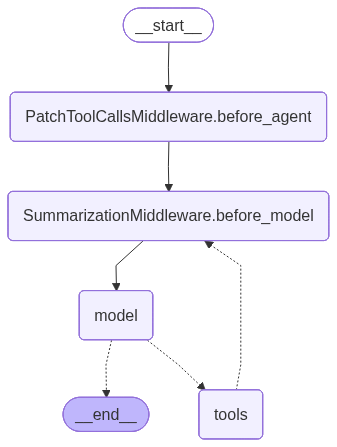

In [8]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [9]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research context engineering approaches used to build AI agents",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research context engineering approaches used to build AI agents                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to /research_request.md",                                   │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,          │
│ examples, best practices, and sources with URLs.",                                                              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report.",                                                                         │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write a comprehensive final report to /final_report.md following Report Writing Guidelines    │
│ (use overview structure: Overview, Key concepts/approaches, Examples, Best practices, Conclusion; inline        │
│ citations; Sources section).",                                                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify by reading /research_request.md and /final_report.md, confirm all aspects addressed    │
│ with citations and structure. Mark all todos complete if done.",                                                │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_72931662                                    

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to /research_request.md", 'status':        │
│ 'in_progress'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a │
│ single research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,   │
│ examples, best practices, and sources with URLs.", 'status': 'pending'}, {'content': 'Synthesize sub-agent      │
│ findings, consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report.',    │
│ 'status': 'pending'}, {'content': 'Write a comprehensive final report to /final_report.md following Report      │
│ Writing Guidelines (use overview structure: Overview, Key concepts/approaches, Examples, Best practices,        │
│ Conclusion; inline citations; Sources section).', 'status': 'pending'}, {'content': 'Verify by reading          │
│ /research_request.md and /final_report.md, confirm all aspects addressed with citations and structure. Mark all │
│ todos complete if done.', 'status': 'pending'}]                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to /research_request.md",                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,          │
│ examples, best practices, and sources with URLs.",                                                              │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report.",                                                                         │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write a comprehensive final report to /final_report.md following Report Writing Guidelines    │
│ (use overview structure: Overview, Key concepts/approaches, Examples, Best practices, Conclusion; inline        │
│ citations; Sources section).",                                                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify by reading /research_request.md and /final_report.md, confirm all aspects addressed    │
│ with citations and structure. Mark all todos complete if done.",                                                │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_77192644                                    

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to /research_request.md", 'status':        │
│ 'completed'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a   │
│ single research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,   │
│ examples, best practices, and sources with URLs.", 'status': 'in_progress'}, {'content': 'Synthesize sub-agent  │
│ findings, consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report.',    │
│ 'status': 'pending'}, {'content': 'Write a comprehensive final report to /final_report.md following Report      │
│ Writing Guidelines (use overview structure: Overview, Key concepts/approaches, Examples, Best practices,        │
│ Conclusion; inline citations; Sources section).', 'status': 'pending'}, {'content': 'Verify by reading          │
│ /research_request.md and /final_report.md, confirm all aspects addressed with citations and structure. Mark all │
│ todos complete if done.', 'status': 'pending'}]                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ## Definition and Overview of Context Engineering                                                               │
│                                                                                                                 │
│ Context engineering is the practice of designing how an AI agent's context window is structured and dynamically │
│ modified, particularly for long-running, stateful agents rather than simple workflows [1]. It treats context as │
│ a valuable, scarce resource that must be carefully managed to enable agents to maintain persistent memory,      │
│ handle tools, and evolve state over time. Unlike basic prompt engineering, which focuses on static              │
│ instructions, context engineering encompasses the full "anatomy" of the context window—including system         │
│ prompts, tool schemas, metadata, memory blocks, files/artifacts, and message buffers—and how these components   │
│ are designed, inserted, and updated dynamically [1]. This approach draws analogies to operating systems, where  │
│ an "LLM OS" (like frameworks such as Letta) manages kernel context (persistent state like memory blocks and     │
│ files) and user context (transient message buffers), using tools as "system calls" to modify state without      │
│ overflowing the LLM's limited window [1].                                                                       │
│                                                                                                                 │
│ ## Key Approaches and Techniques                                                                                │
│                                                                                                                 │
│ Key techniques in context engineering build on prompt engineering variants but extend to memory management,     │
│ tool integration, and state management. **Prompt engineering variants** include system prompts that define      │
│ agent architecture, control flow, and core concepts (e.g., explaining memory blocks or tools) [1]. **Memory     │
│ management** uses structures like memory blocks—persistent, labeled units with size limits, descriptions, and   │
│ access controls (e.g., read-only)—to store long-term knowledge or working context, preventing degradation over  │
│ sessions [1]. Agents or background processes can modify these via tools like `memory_replace`,                  │
│ `memory_rethink`, or `memory_append` [1]. **Tool integration** distinguishes system tools (privileged for state │
│ modification, e.g., file operations like `open`, `grep`) from custom/user tools (for external data retrieval    │
│ via protocols like Model Context Protocol or MCP) [1]. **State management** involves kernel/user separation:    │
│ kernel context (system-managed, mutable via APIs/tools) for persistence, and user context (message buffer with  │
│ user/assistant/system messages, tool calls) for interaction [1]. Files and artifacts provide scalable storage   │
│ (e.g., open/closed files, vector/grep search), while dynamic evolution pulls external context or prunes buffers │
│ to avoid overflow [1]. In LangChain, memory types like `ConversationBufferMemory` (short-term history) and      │
│ `ConversationSummaryMemory` (summarization for long contexts) integrate with vector stores (e.g., Pinecone,     │
│ Chroma) for persistence [2].                                                                                    │
│                                                                                                                 │
│ ## Real-World Examples from Popular AI Agent Frameworks                                                         │
│                                                                                                                 │
│ In **Letta** (formerly MemGPT), context engineering is 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to /research_request.md",                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,          │
│ examples, best practices, and sources with URLs.",                                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report.",                                                                         │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write a comprehensive final report to /final_report.md following Report Writing Guidelines    │
│ (use overview structure: Overview, Key concepts/approaches, Examples, Best practices, Conclusion; inline        │
│ citations; Sources section).",                                                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify by reading /research_request.md and /final_report.md, confirm all aspects addressed    │
│ with citations and structure. Mark all todos complete if done.",                                                │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_76808424                                    

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to /research_request.md", 'status':        │
│ 'completed'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a   │
│ single research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,   │
│ examples, best practices, and sources with URLs.", 'status': 'completed'}, {'content': 'Synthesize sub-agent    │
│ findings, consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report.',    │
│ 'status': 'in_progress'}, {'content': 'Write a comprehensive final report to /final_report.md following Report  │
│ Writing Guidelines (use overview structure: Overview, Key concepts/approaches, Examples, Best practices,        │
│ Conclusion; inline citations; Sources section).', 'status': 'pending'}, {'content': 'Verify by reading          │
│ /research_request.md and /final_report.md, confirm all aspects addressed with citations and structure. Mark all │
│ todos complete if done.', 'status': 'pending'}]                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to /research_request.md",                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,          │
│ examples, best practices, and sources with URLs.",                                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report.",                                                                         │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write a comprehensive final report to /final_report.md following Report Writing Guidelines    │
│ (use overview structure: Overview, Key concepts/approaches, Examples, Best practices, Conclusion; inline        │
│ citations; Sources section).",                                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify by reading /research_request.md and /final_report.md, confirm all aspects addressed    │
│ with citations and structure. Mark all todos complete if done.",                                                │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_67874334                                    

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to /research_request.md", 'status':        │
│ 'completed'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a   │
│ single research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,   │
│ examples, best practices, and sources with URLs.", 'status': 'completed'}, {'content': 'Synthesize sub-agent    │
│ findings, consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report.',    │
│ 'status': 'completed'}, {'content': 'Write a comprehensive final report to /final_report.md following Report    │
│ Writing Guidelines (use overview structure: Overview, Key concepts/approaches, Examples, Best practices,        │
│ Conclusion; inline citations; Sources section).', 'status': 'completed'}, {'content': 'Verify by reading        │
│ /research_request.md and /final_report.md, confirm all aspects addressed with citations and structure. Mark all │
│ todos complete if done.', 'status': 'in_progress'}]                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  research context engineering approaches used to build AI agents                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  ## Overview of Context Engineering                                                                      │
│      2                                                                                                          │
│      3  Context engineering involves designing and dynamically managing the structure of an AI agent's context  │
│ window, especially for stateful, long-running agents. It treats the context as a scarce resource, extending     │
│ beyond static prompt engineering to encompass the full composition of the context window, including system      │
│ prompts, tool schemas, metadata, memory blocks, files, artifacts, and message buffers. These elements are       │
│ inserted, updated, and modified over time to maintain persistence, handle tools, and manage state effectively.  │
│ Analogous to an operating system, context engineering features an \"LLM OS\" that separates kernel context      │
│ (persistent state) from user context (transient interactions), using tools as system calls to prevent context   │
│ overflow [1].                                                                                                   │
│      4                                                                                                          │
│      5  ## Key Approaches and Techniques                                                                        │
│      6                                                                                                          │
│      7  Core techniques in context engineering include advanced prompt engineering, memory management, tool     │
│ integration, and state management. System prompts define the agent's architecture, control flow, and concepts   │
│ like memory blocks or tools. Memory management employs persistent, labeled memory blocks with size limits,      │
│ descriptions, and access controls, modified via tools such as memory_replace, memory_rethink, or memory_append  │
│ to preserve long-term knowledge without degradation. Tool integration differentiates system tools for state     │
│ changes (e.g., file operations) from user tools for external data via protocols like Model Context Protocol     │
│ (MCP). State management maintains a kernel-user separation, with kernel context for mutable persistence and     │
│ user context for message buffers containing interactions and tool calls. Additional elements include files and  │
│ artifacts for scalable storage, dynamic context evolution through retrieval or pruning, and integration with    │
│ vector stores for semantic search [1][2].                                                                       │
│      8                                                                                                          │
│      9  ## Examples in AI Agent Frameworks                                                                      │
│     10                                                                                                          │
│     11  Frameworks like Letta (formerly MemGPT) exemplify context engineering with memory blocks for recall,    │
│ files for data handling (e.g., PDFs), and an Agent Development Environment (ADE) for visualization. Agents      │
│ self-modify state using tools, including offline memory rewriting during sleep periods. LangChain offers memory │
│ solutions such as ConversationBufferMemory for short-term history, ConversationSummaryMemory for long-context   │
│ summarization, and vector store integrations like Pinecone or Chroma for persistent retrieval, commonly used in │
│ agent executors for multi-turn dialogues. AutoGPT and CrewAI draw from similar principles, with MemGPT          │
│ influencing autonomous state management and CrewAI emphasizing multi-agent shared memory and tool chaining      │
│ [1][2].                                                

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to /research_request.md",                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,          │
│ examples, best practices, and sources with URLs.",                                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report.",                                                                         │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write a comprehensive final report to /final_report.md following Report Writing Guidelines    │
│ (use overview structure: Overview, Key concepts/approaches, Examples, Best practices, Conclusion; inline        │
│ citations; Sources section).",                                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify by reading /research_request.md and /final_report.md, confirm all aspects addressed    │
│ with citations and structure. Mark all todos complete if done.",                                                │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_52576384                                    

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to /research_request.md", 'status':        │
│ 'completed'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a   │
│ single research-agent subagent. Instruct it to provide a comprehensive summary of approaches, key techniques,   │
│ examples, best practices, and sources with URLs.", 'status': 'completed'}, {'content': 'Synthesize sub-agent    │
│ findings, consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report.',    │
│ 'status': 'completed'}, {'content': 'Write a comprehensive final report to /final_report.md following Report    │
│ Writing Guidelines (use overview structure: Overview, Key concepts/approaches, Examples, Best practices,        │
│ Conclusion; inline citations; Sources section).', 'status': 'completed'}, {'content': 'Verify by reading        │
│ /research_request.md and /final_report.md, confirm all aspects addressed with citations and structure. Mark all │
│ todos complete if done.', 'status': 'completed'}]                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Overview of Context Engineering                                                                              │
│                                                                                                                 │
│ Context engineering involves designing and dynamically managing the structure of an AI agent's context window,  │
│ especially for stateful, long-running agents. It treats the context as a scarce resource, extending beyond      │
│ static prompt engineering to encompass the full composition of the context window, including system prompts,    │
│ tool schemas, metadata, memory blocks, files, artifacts, and message buffers. These elements are inserted,      │
│ updated, and modified over time to maintain persistence, handle tools, and manage state effectively. Analogous  │
│ to an operating system, context engineering features an "LLM OS" that separates kernel context (persistent      │
│ state) from user context (transient interactions), using tools as system calls to prevent context overflow [1]. │
│                                                                                                                 │
│ ## Key Approaches and Techniques                                                                                │
│                                                                                                                 │
│ Core techniques in context engineering include advanced prompt engineering, memory management, tool             │
│ integration, and state management. System prompts define the agent's architecture, control flow, and concepts   │
│ like memory blocks or tools. Memory management employs persistent, labeled memory blocks with size limits,      │
│ descriptions, and access controls, modified via tools such as memory_replace, memory_rethink, or memory_append  │
│ to preserve long-term knowledge without degradation. Tool integration differentiates system tools for state     │
│ changes (e.g., file operations) from user tools for external data via protocols like Model Context Protocol     │
│ (MCP). State management maintains a kernel-user separation, with kernel context for mutable persistence and     │
│ user context for message buffers containing interactions and tool calls. Additional elements include files and  │
│ artifacts for scalable storage, dynamic context evolution through retrieval or pruning, and integration with    │
│ vector stores for semantic search [1][2].                                                                       │
│                                                                                                                 │
│ ## Examples in AI Agent Frameworks                                                                              │
│                                                                                                                 │
│ Frameworks like Letta (formerly MemGPT) exemplify context engineering with memory blocks for recall, files for  │
│ data handling (e.g., PDFs), and an Agent Development Environment (ADE) for visualization. Agents self-modify    │
│ state using tools, including offline memory rewriting during sleep periods. LangChain offers memory solutions   │
│ such as ConversationBufferMemory for short-term history, ConversationSummaryMemory for long-context             │
│ summarization, and vector store integrations like Pinecone or Chroma for persistent retrieval, commonly used in │
│ agent executors for multi-turn dialogues. AutoGPT and CrewAI draw from similar principles, with MemGPT          │
│ influencing autonomous state management and CrewAI emphasizing multi-agent shared memory and tool chaining      │
│ [1][2].                                                                                                         │
│                                                        

In [10]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  ## Overview of Context Engineering                                                                             │
│                                                                                                                 │
│  Context engineering involves designing and dynamically managing the structure of an AI agent's context         │
│  window, especially for stateful, long-running agents. It treats the context as a scarce resource, extending    │
│  beyond static prompt engineering to encompass the full composition of the context window, including system     │
│  prompts, tool schemas, metadata, memory blocks, files, artifacts, and message buffers. These elements are      │
│  inserted, updated, and modified over time to maintain persistence, handle tools, and manage state              │
│  effectively. Analogous to an operating system, context engineering features an \"LLM OS\" that separates       │
│  kernel context (persistent state) from user context (transient interactions), using tools as system calls to   │
│  prevent context overflow [1].                                                                                  │
│                                                                                                                 │
│  ## Key Approaches and Techniques                                                                               │
│                                                                                                                 │
│  Core techniques in context engineering include advanced prompt engineering, memory management, tool            │
│  integration, and state management. System prompts define the agent's architecture, control flow, and concepts  │
│  like memory blocks or tools. Memory management employs persistent, labeled memory blocks with size limits,     │
│  descriptions, and access controls, modified via tools such as memory_replace, memory_rethink, or               │
│  memory_append to preserve long-term knowledge without degradation. Tool integration differentiates system      │
│  tools for state changes (e.g., file operations) from user tools for external data via protocols like Model     │
│  Context Protocol (MCP). State management maintains a kernel-user separation, with kernel context for mutable   │
│  persistence and user context for message buffers containing interactions and tool calls. Additional elements   │
│  include files and artifacts for scalable storage, dynamic context evolution through retrieval or pruning, and  │
│  integration with vector stores for semantic search [1][2].                                                     │
│                                                                                                                 │
│  ## Examples in AI Agent Frameworks                                                                             │
│                                                                                                                 │
│  Frameworks like Letta (formerly MemGPT) exemplify context engineering with memory blocks for recall, files     │
│  for data handling (e.g., PDFs), and an Agent Development Environment (ADE) for visualization. Agents           │
│  self-modify state using tools, including offline memory rewriting during sleep periods. LangChain offers       │
│  memory solutions such as ConversationBufferMemory for short-term history, ConversationSummaryMemory for        │
│  long-context summarization, and vector store integrations like Pinecone or Chroma for persistent retrieval,    │
│  commonly used in agent executors for multi-turn dialogues. AutoGPT and CrewAI draw from similar principles,    │
│  with MemGPT influencing autonomous state management a